# Content Analysis

In [1]:
import arviz as az
import bambi as bmb
from bambi.plots import plot_cap
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_json('data/year_predictions.json')
df['image_id'] = np.random.permutation(len(df))

# adding paths
df2 = pd.read_json('data/image_data.json')
df['paths'] = df2[0]

# calculating error rate
df['error_bw'] = df['actual_year'] - df['year_pred']
df['error_bw_abs'] = df['error_bw'].abs()


<Axes: title={'center': 'distribution of absolute error'}, ylabel='Frequency'>

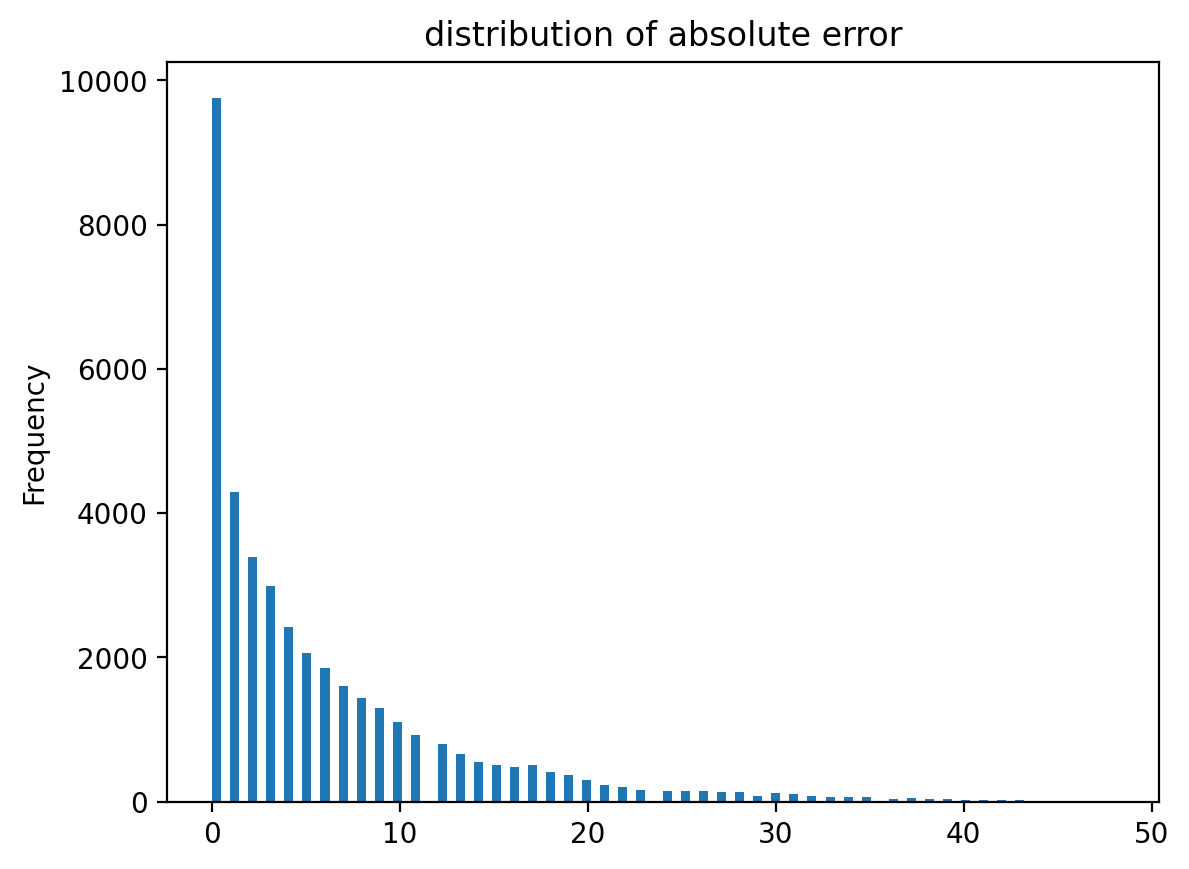

In [3]:
df['error_bw_abs'].plot.hist(bins=100, title='distribution of absolute error')

In [4]:
df['error_rate'] = df['error_bw_abs'] / (df['error_bw_abs'].max() - df['error_bw_abs'].min())

In [5]:
# add cut-off to confidence score for object detection
confidence = 0.8
df['objects'] = df['objects'].apply(lambda x: [item for item in x if item[1] >= confidence])

# only keep object names and remove confidence scores
df['objects'] = df['objects'].apply(lambda x: [sublist[0] for sublist in x if len(sublist) > 0]).tolist()

In [6]:
# dummy-encode labels
mlb = MultiLabelBinarizer()

encoded_array = mlb.fit_transform(df['objects'])
encoded_df = pd.DataFrame(encoded_array, columns=mlb.classes_)
encoded_df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

for col in encoded_df.columns:
    encoded_df[col] = encoded_df[col].astype('category')
df = pd.concat([df.drop('objects', axis=1), encoded_df], axis=1)


In [7]:
result = ' + '.join(encoded_df.columns)
    

<Axes: >

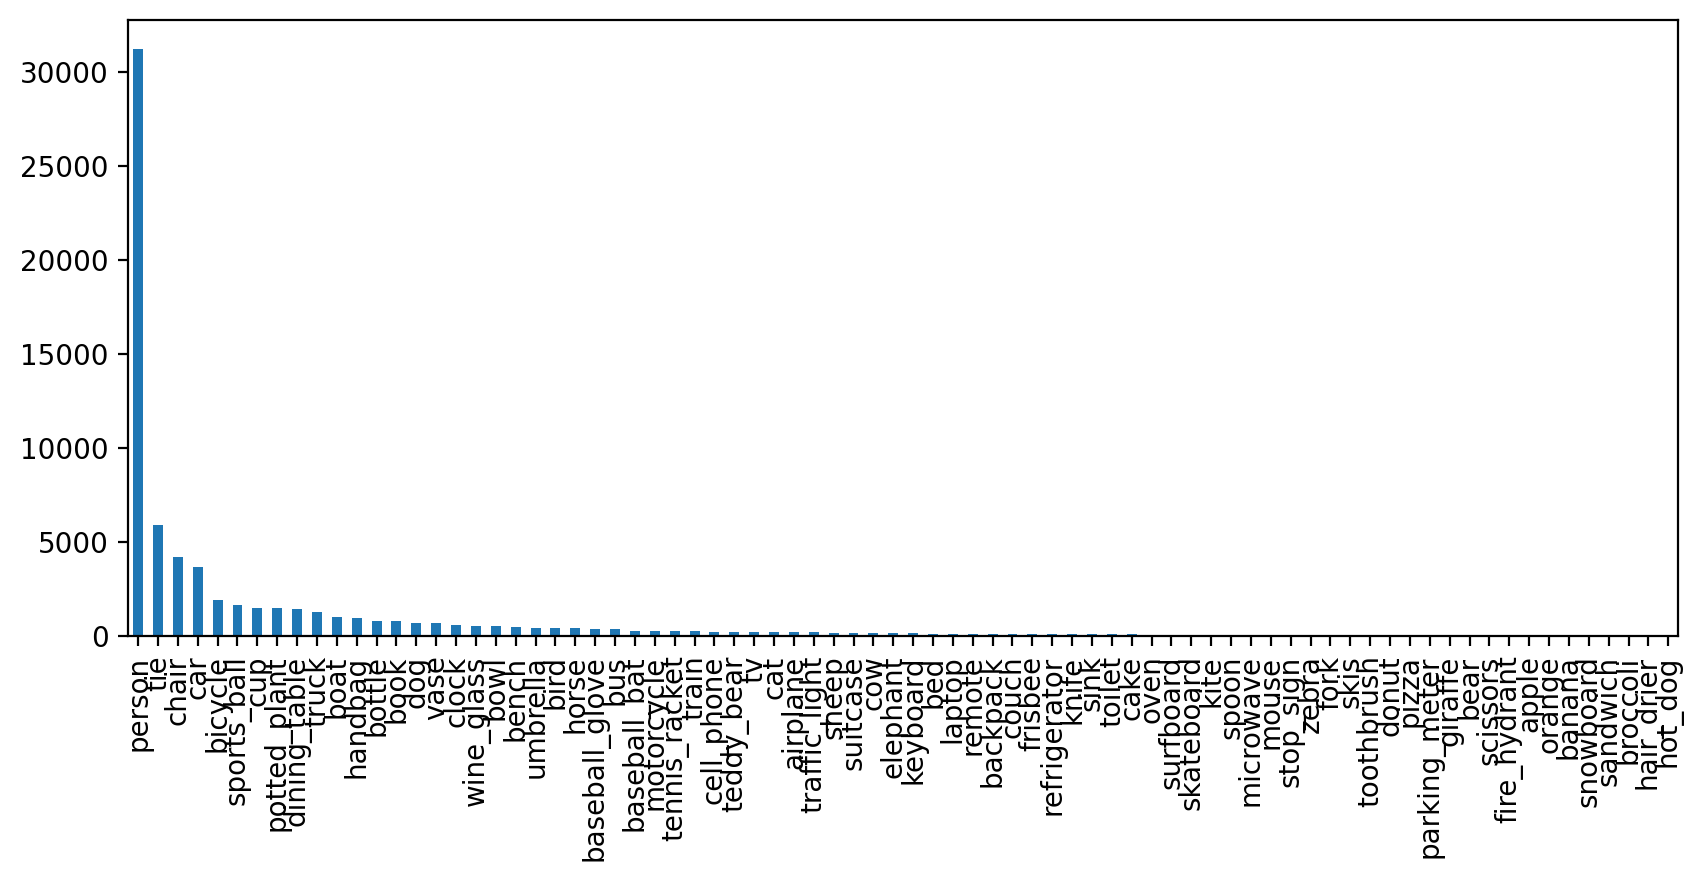

In [8]:
column_counts = encoded_df.eq(1).sum()
column_counts.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))


In [9]:
# only select labels that occur more than 200 times
selected_labels = {k: v for k, v in column_counts.items() if v > 200}


In [10]:
# selected_columns = []
# for column in encoded_df.columns:
#     if column in selected_labels.keys():
#         selected_columns.append(column)
# result = ' + '.join(selected_columns)   

In [11]:
# only select labels that fit within these three categories, excluding sub-labels
transportation = ['bicycle', 'boat', 'bus', 'car', 'motorcycle', 'train', 'truck']
animals = ['bird', 'cat', 'dog', 'horse']
person = ['person']

selected_columns = transportation + animals + person

In [12]:
# print strings for easy copy-pasting into model definition, as f'string will not work

In [13]:
' + '.join(selected_columns)

'bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person'

In [14]:
', '.join(['"{}"'.format(item) for item in selected_columns])

'"bicycle", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"'

## Modeling

### Zero Inflated Poisson

Initially, I decided to model this as counts. However, as reviewer 3 rightly pointed out, it might be better not to view this as a Poisson. I tried to approach it as a zero-inflated beta using error rates, but I ended up using beta using the absolute error rates. Also since the mean and variance were very different, violating one of the assumptions for a Poisson distribution.

In [15]:
model = bmb.Model(f'error_bw_abs ~ 1 + bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person', 
                        df, 
                        family='zero_inflated_poisson')

In [16]:
# # Fit the model using 1000 on each of 4 chains
results = model.fit(draws=2500, chains=4, inference_method='nuts_numpyro')



Compiling...
Compilation time =  0:00:08.174450
Sampling...


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling time =  0:02:33.205851
Transforming variables...
Transformation time =  0:00:00.054907


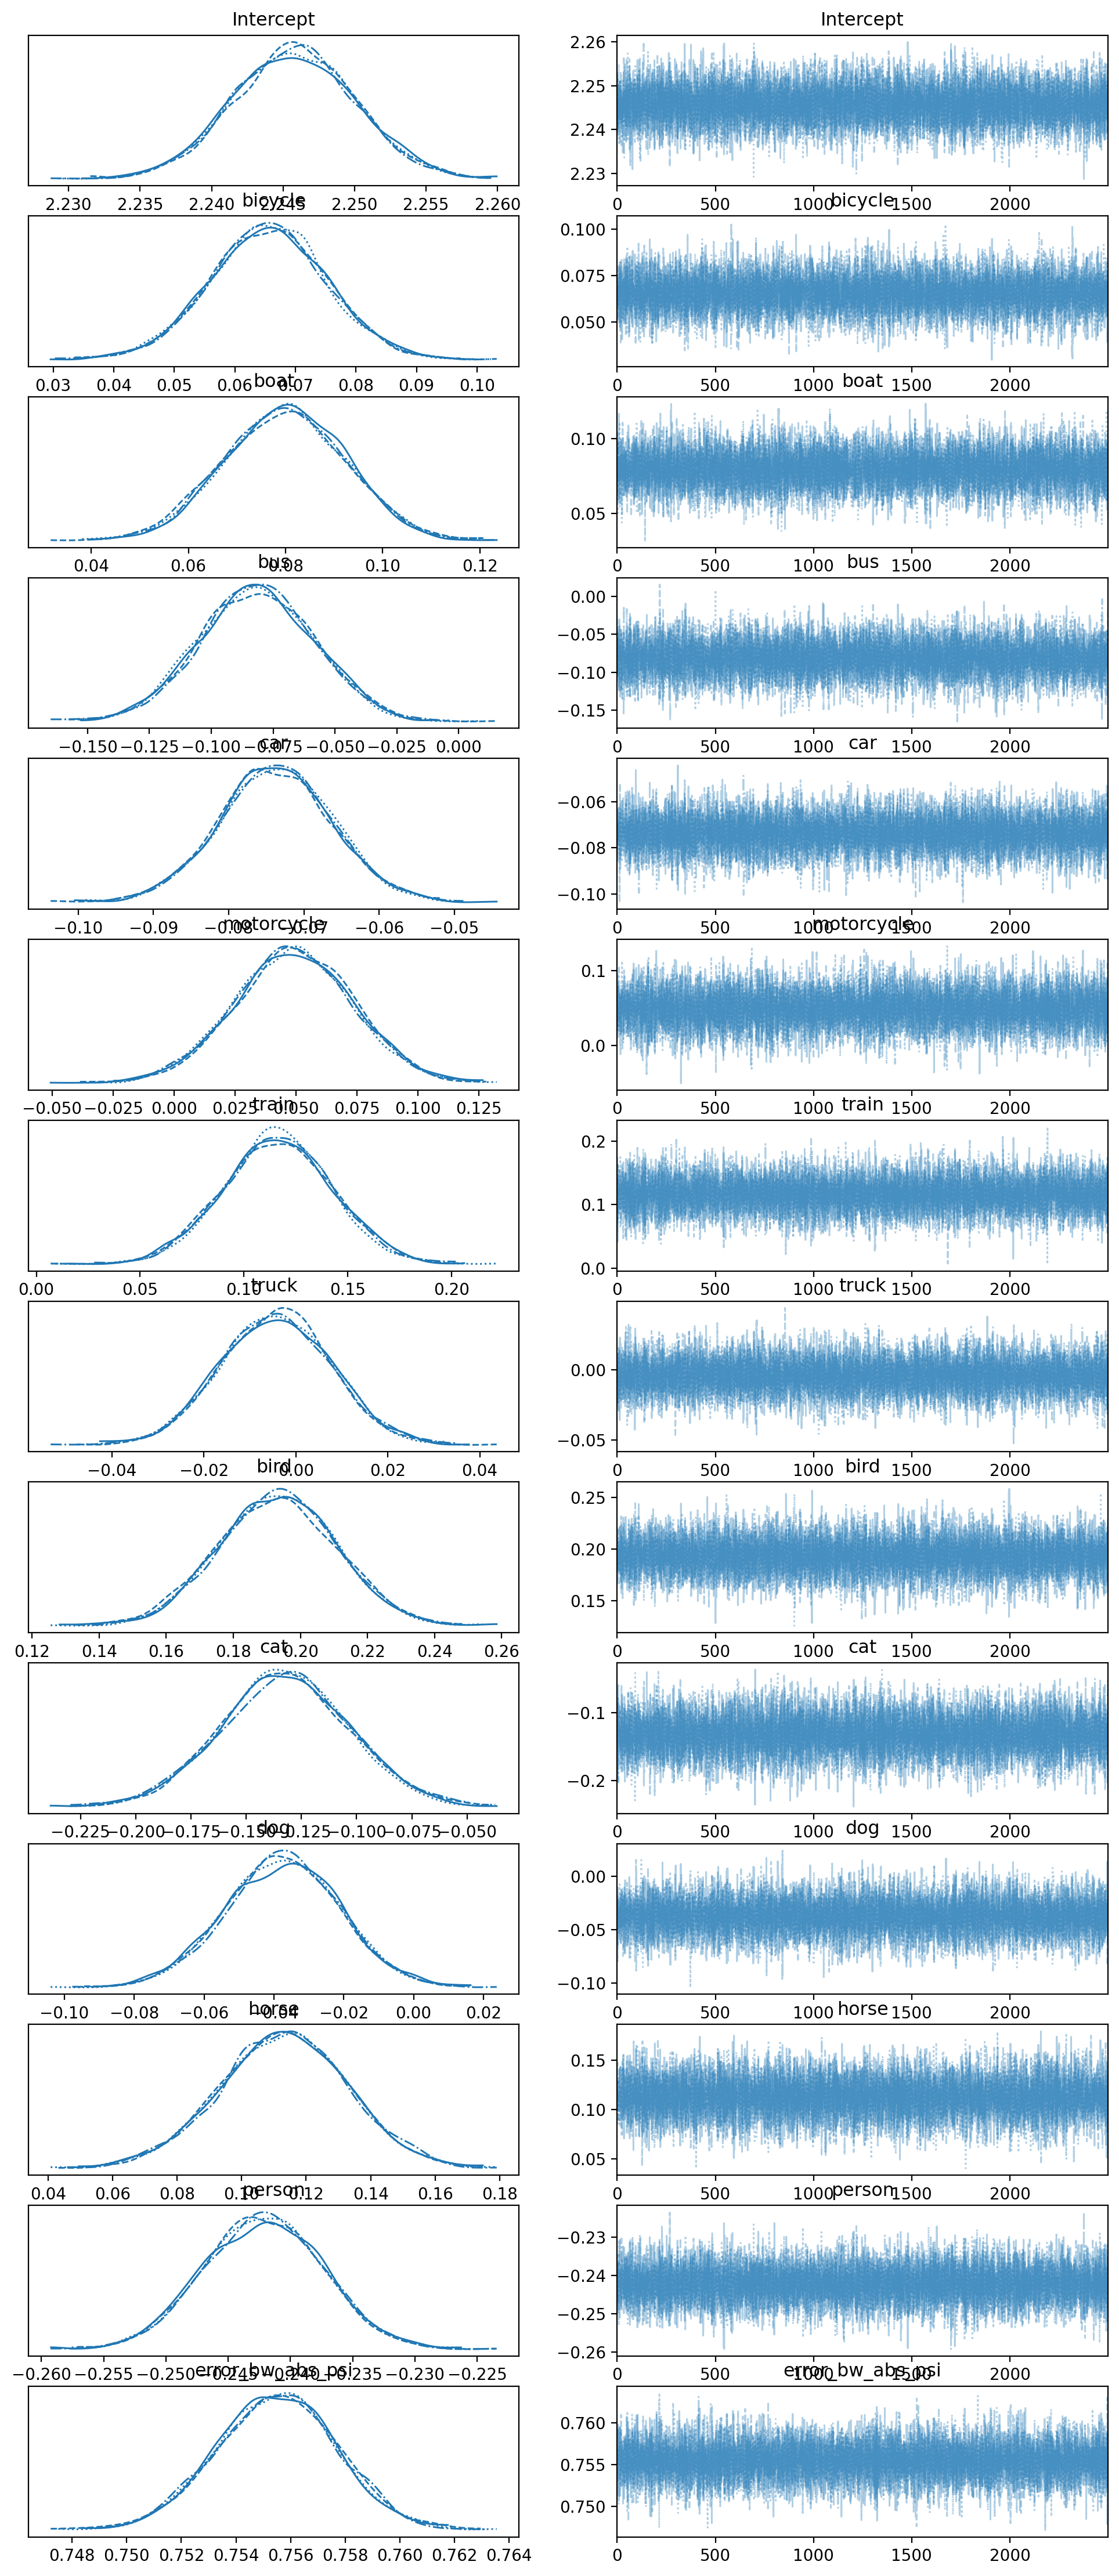

In [17]:
az.plot_trace(results);

In [18]:
az.summary(results)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept         2.246  0.004   2.238    2.254        0.0      0.0   18684.0   
bicycle[1]        0.065  0.010   0.048    0.085        0.0      0.0   17358.0   
boat[1]           0.080  0.012   0.057    0.103        0.0      0.0   19039.0   
bus[1]           -0.082  0.023  -0.123   -0.038        0.0      0.0   13964.0   
car[1]           -0.074  0.008  -0.088   -0.060        0.0      0.0   18314.0   
motorcycle[1]     0.049  0.024   0.003    0.094        0.0      0.0   14635.0   
train[1]          0.116  0.026   0.067    0.165        0.0      0.0   18865.0   
truck[1]         -0.004  0.012  -0.027    0.017        0.0      0.0   16576.0   
bird[1]           0.193  0.017   0.160    0.225        0.0      0.0   17262.0   
cat[1]           -0.133  0.029  -0.187   -0.078        0.0      0.0   17893.0   
dog[1]           -0.038  0.016  -0.068   -0.007        0.0      0.0   17639.0   
horse[1]          0.113  0.020   0.076    0.151        0.0      0.0   18789.0   
person[1]        -0.242  0.005  -0.251   -0.233        0.0      0.0   21967.0   
error_bw_abs_psi  0.755  0.002   0.751    0.760        0.0      0.0   20940.0   

                  ess_tail  r_hat  
Intercept           8521.0    1.0  
bicycle[1]          7817.0    1.0  
boat[1]             7223.0    1.0  
bus[1]              7792.0    1.0  
car[1]              8222.0    1.0  
motorcycle[1]       8274.0    1.0  
train[1]            7226.0    1.0  
truck[1]            7355.0    1.0  
bird[1]             7223.0    1.0  
cat[1]              7765.0    1.0  
dog[1]              7570.0    1.0  
horse[1]            7392.0    1.0  
person[1]           7970.0    1.0  
error_bw_abs_psi    7804.0    1.0

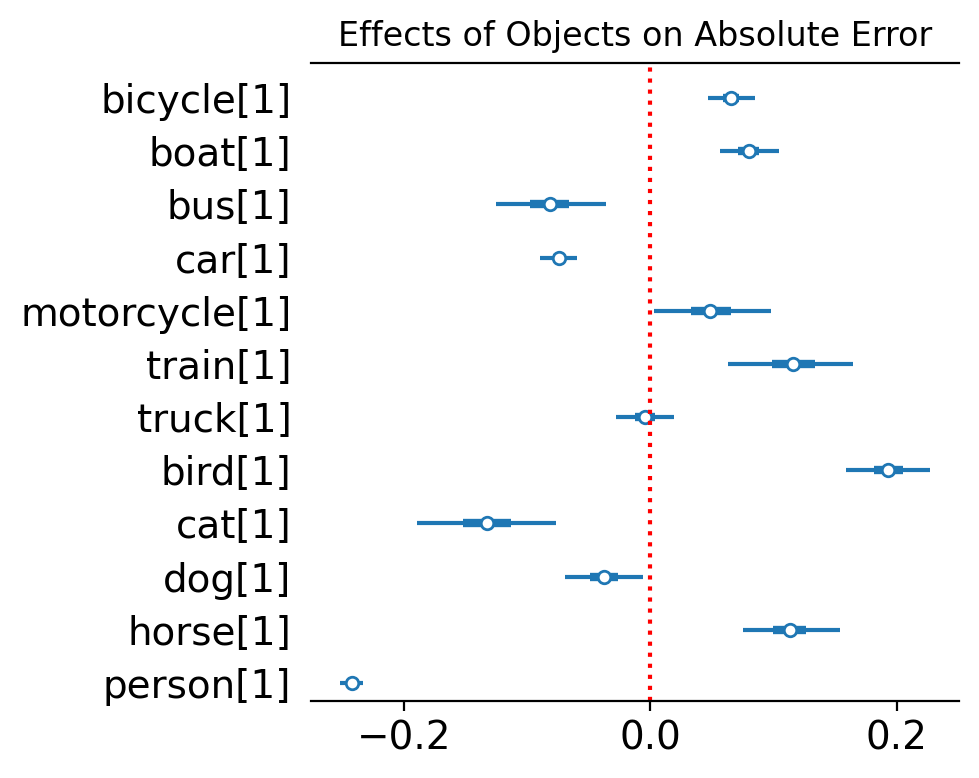

In [19]:
ax= az.plot_forest(
    results,
    combined=True,
    #filter_vars='like',
    #kind = 'ridgeplot',
    var_names = selected_columns,
    #var_names = ['person'],
    #var_names = ["bicycle", "boat", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"],
    figsize=(5, 4),
    hdi_prob=0.95,
);
ax[0].axvline(0, color="red", linestyle="dotted")
plt.title('Effects of Objects on Absolute Error')
plt.tight_layout()
plt.savefig('figures/effects_ZIP.png', dpi=300)

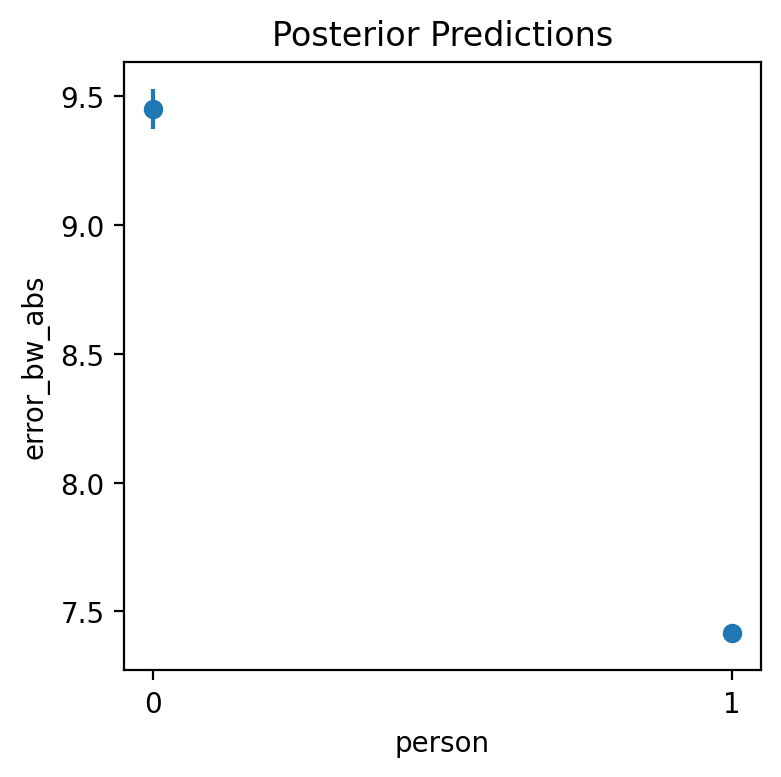

In [20]:


fig, ax = plt.subplots(figsize=(4, 4))
plot_cap(model, results, ["person"], ax=ax);
plt.title('Posterior Predictions')
plt.tight_layout()
plt.savefig('figures/predictions_ZIP.png', dpi=300)

### Negative Binomial

In [21]:
model2 = bmb.Model(f'error_bw_abs ~ 1 + bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person', 
                        df, 
                        family='negativebinomial')

In [22]:
results2 = model2.fit(draws=2500, chains=4, inference_method='nuts_numpyro')



Compiling...
Compilation time =  0:00:07.509129
Sampling...


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

Sampling time =  0:03:09.005132
Transforming variables...
Transformation time =  0:00:00.026807


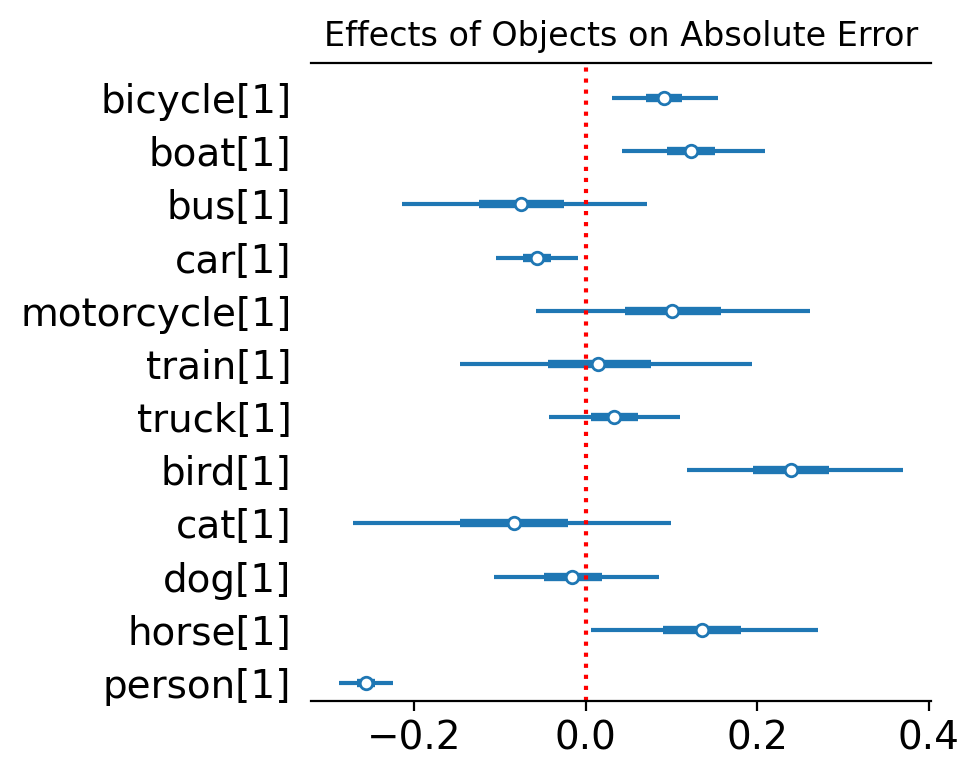

In [23]:
ax= az.plot_forest(
    results2,
    combined=True,
    #filter_vars='like',
    #kind = 'ridgeplot',
    var_names = selected_columns,
    #var_names = ['person'],
    #var_names = ["bicycle", "boat", "boat", "bus", "car", "motorcycle", "train", "truck", "bird", "cat", "dog", "horse", "person"],
    figsize=(5, 4),
    hdi_prob=0.95,
);
ax[0].axvline(0, color="red", linestyle="dotted")
plt.title('Effects of Objects on Absolute Error')
plt.tight_layout()
plt.savefig('figures/effects_negbinomial.png', dpi=300)

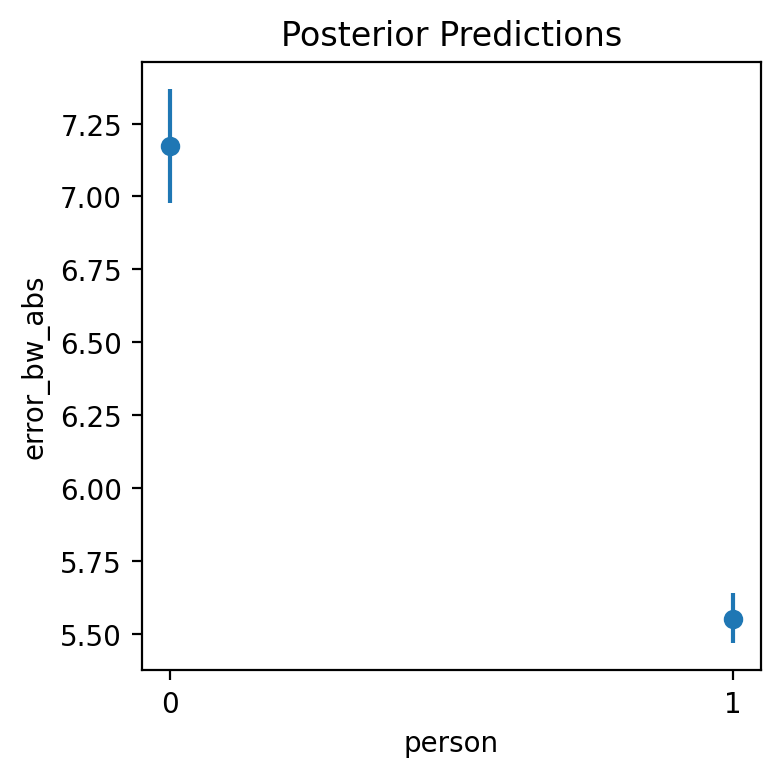

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_cap(model2, results2, ["person"], ax=ax);
plt.title('Posterior Predictions')
plt.tight_layout()
plt.savefig('figures/predictions_negbinomial.png', dpi=300)

In [25]:
model2

       Formula: error_bw_abs ~ 1 + bicycle + boat + bus + car + motorcycle + train + truck + bird + cat + dog + horse + person
        Family: negativebinomial
          Link: mu = log
  Observations: 39866
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.5169)
            bicycle ~ Normal(mu: 0.0, sigma: 11.7229)
            boat ~ Normal(mu: 0.0, sigma: 16.1528)
            bus ~ Normal(mu: 0.0, sigma: 26.5375)
            car ~ Normal(mu: 0.0, sigma: 8.675)
            motorcycle ~ Normal(mu: 0.0, sigma: 30.7657)
            train ~ Normal(mu: 0.0, sigma: 33.0807)
            truck ~ Normal(mu: 0.0, sigma: 14.2408)
            bird ~ Normal(mu: 0.0, sigma: 24.343)
            cat ~ Normal(mu: 0.0, sigma: 35.2973)
            dog ~ Normal(mu: 0.0, sigma: 19.3074)
            horse ~ Normal(mu: 0.0, sigma: 25.0224)
            person ~ Normal(mu: 0.0, sigma: 6.0591)
        
        Auxiliary parameters
            alpha ~ 

In [26]:
az.summary(results2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           1.970  0.015   1.943    1.997      0.000    0.000   
bicycle[1]          0.091  0.032   0.031    0.149      0.000    0.000   
boat[1]             0.123  0.042   0.043    0.203      0.000    0.000   
bus[1]             -0.075  0.073  -0.214    0.061      0.000    0.001   
car[1]             -0.057  0.024  -0.103   -0.011      0.000    0.000   
motorcycle[1]       0.102  0.082  -0.044    0.261      0.001    0.001   
train[1]            0.017  0.088  -0.143    0.184      0.001    0.001   
truck[1]            0.033  0.039  -0.040    0.107      0.000    0.000   
bird[1]             0.239  0.065   0.118    0.358      0.000    0.000   
cat[1]             -0.083  0.094  -0.257    0.099      0.001    0.001   
dog[1]             -0.015  0.050  -0.111    0.076      0.000    0.001   
horse[1]            0.136  0.067   0.006    0.260      0.000    0.000   
person[1]          -0.256  0.016  -0.287   -0.227      0.000    0.000   
error_bw_abs_alpha  0.635  0.005   0.625    0.645      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
Intercept            24530.0    7633.0    1.0  
bicycle[1]           22669.0    8112.0    1.0  
boat[1]              23948.0    7308.0    1.0  
bus[1]               27599.0    7501.0    1.0  
car[1]               20184.0    8072.0    1.0  
motorcycle[1]        25109.0    7664.0    1.0  
train[1]             23921.0    7159.0    1.0  
truck[1]             21833.0    7222.0    1.0  
bird[1]              24676.0    7503.0    1.0  
cat[1]               22728.0    7926.0    1.0  
dog[1]               21999.0    7631.0    1.0  
horse[1]             24216.0    7838.0    1.0  
person[1]            24012.0    7977.0    1.0  
error_bw_abs_alpha   22641.0    7145.0    1.0